In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from langdetect import detect
import langdetect
from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import FunctionTransformer
import en_core_web_lg
from tqdm import tqdm_pandas, tqdm_notebook
import tokenize_uk
import warnings

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_colwidth', 100)

In [3]:
nlp = en_core_web_lg.load()

# Loading data

In [6]:
df = pd.read_csv('scraper/data-phones.csv.gz', compression='gzip')
df['review'] = df['review'].apply(json.loads)
#df['scores'] = df['scores'].apply(json.loads)
print("Rows: ", len(df))
df.head()

Rows:  49890


,review,id,scores
0,{'_': 'Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая поло...,18896982,NaN
1,{'_': 'Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише ...,18840918,NaN
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0
3,{'_': 'Он полностю новий?'},18736812,5.0
4,"{'_': 'Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s та...",18534645,4.0


For now just stick with main part of review

In [314]:
df['main_review'] = df['review'].apply(lambda x: x['_'])
df.head()

,review,id,scores,main_review
0,{'_': 'Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая поло...,18896982,NaN,Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая полоска и з...
1,{'_': 'Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише ...,18840918,NaN,Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише в трьох...
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування"
3,{'_': 'Он полностю новий?'},18736812,5.0,Он полностю новий?
4,"{'_': 'Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s та...",18534645,4.0,"Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s так же пр..."


Filter those written in ukrainian

In [315]:
def detect_lang(x):
    try:
        return detect(x)
    except langdetect.lang_detect_exception.LangDetectException:
        pass
        
df_uk = df[df['main_review'].progress_apply(detect_lang) == 'uk'].copy()
print("Rows: ", len(df_uk))
df_uk.head()


Rows:  10231


,review,id,scores,main_review
0,{'_': 'Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая поло...,18896982,NaN,Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая полоска и з...
1,{'_': 'Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише ...,18840918,NaN,Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише в трьох...
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування"
3,{'_': 'Он полностю новий?'},18736812,5.0,Он полностю новий?
4,"{'_': 'Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s та...",18534645,4.0,"Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s так же пр..."


Leave only those with scores

In [318]:
main_key = 'Общее впечатление'
taste_key = 'Соответствие вкуса'
aroma_key = 'Соответствие аромата'
def combine_scores(scores):
    if main_key in scores:
        main = scores.get(main_key)
        taste = scores.get(taste_key)
        aroma = scores.get(aroma_key)
        raws = list(filter(lambda x: x, [main, taste, aroma]))
        return np.mean(raws)
df_uk = df_uk.assign(score_raw=df_uk['scores'])
df_ws = df_uk[pd.notna(df_uk['score_raw'])].copy()
print("Rows: ", len(df_ws))
df_ws.head()

Rows:  4317


,review,id,scores,main_review,score_raw
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування",5.0
12,{'_': 'Запитання: чи є в ньому функцію запису телефонної розмови?'},19373305,4.0,Запитання: чи є в ньому функцію запису телефонної розмови?,4.0
15,{'_': 'Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі скан...,21074865,5.0,"Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі сканером, х...",5.0
22,"{'_': 'Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?', 'Недоліки:': '-'}",20476907,5.0,Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?,5.0
60,"{'_': 'Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а пр...",16161182,5.0,"Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а простий ч...",5.0


In [340]:
1+4/3,1+4/3+4/3,1+4/3+4/3+4/3

(2.333333333333333, 3.666666666666666, 4.999999999999999)

Digitize scores

In [349]:
def digitize(n):
    if (1 <= n) and (n < 3):
        return 0
    elif (3 <= n) and (n < 4):
        return 1
    elif (4 <= n) and (n <= 5):
        return 2
    else:
        return None
bins = 1+np.array([4/3,2*4/3])
df_ws['score'] = np.digitize(df_ws['score_raw'], bins)
df_ws.head()

,review,id,scores,main_review,score_raw,score
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування",5.0,2
12,{'_': 'Запитання: чи є в ньому функцію запису телефонної розмови?'},19373305,4.0,Запитання: чи є в ньому функцію запису телефонної розмови?,4.0,2
15,{'_': 'Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі скан...,21074865,5.0,"Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі сканером, х...",5.0,2
22,"{'_': 'Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?', 'Недоліки:': '-'}",20476907,5.0,Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?,5.0,2
60,"{'_': 'Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а пр...",16161182,5.0,"Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а простий ч...",5.0,2


In [7]:
#train,test = train_test_split(df_ws, test_size=0.3)
#train.to_csv('train.phones.csv', index=False)
#test.to_csv('test.phones.csv', index=False)
train = pd.read_csv('train.phones.csv.gz', compression='gzip')
test = pd.read_csv('test.phones.csv.gz', compression='gzip')

Load ukranian stemmer (borrowed from https://github.com/Amice13/ukr_stemmer)

In [8]:
%run -n ukr_stemmer3.py

In [9]:
def stem(xs):
    return np.array([UkrainianStemmer(x).stem_word() for x in xs])

def stem_all(X):
    stem_vec = np.vectorize(stem)
    return stem_vec(X)

In [10]:
def tokenize(x, lowercase=False):
    tokens = tokenize_uk.tokenize_words(x)
    if lowercase==True:
        return [tok.lower() for tok in tokens]
    else:
        return tokens

In [11]:
train = train.assign(review_doc = train['main_review'].apply(lambda x: stem(tokenize(x, lowercase=True))))
test = test.assign(review_doc = test['main_review'].apply(lambda x: stem(tokenize(x, lowercase=True))))

In [12]:
vocab = CountVectorizer(tokenizer=lambda x: x, lowercase=False).fit(train['review_doc'], train['score']).vocabulary_
idxs, ivocab = zip(*sorted(zip(vocab.values(),vocab.keys())))
ivocab = np.array(ivocab)

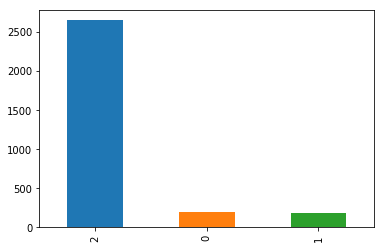

In [13]:
train['score'].value_counts().plot(kind='bar')

# Classification

## Baseline

In [14]:
print("Baseline score:", accuracy_score(test['score'], np.full(test['score'].shape, 2)))

Baseline score: 0.8680555555555556


### Metrics
This task has 3 classes, so simple f1/prec/rec metrics will not be representative. Also the data is substantially skewed towards the `positive` class. I assume that the end user of this classification will want to find the nagative comments and somehow react to them. He, definitely, will not want to look at enourmous number of positive posts. So our metric will target negative class. In addition, we, really, don't care if some positive class was classified as negative, because it is easy to find such error. On the other side, the cost of not labeling negative comment with negative class is huge, there is just no way for user to find this error in the big pile of positive classes. 

I have chosen `F2` score measured for negative class. Also we will look at other compound metrics to not make them too bad

In [63]:
from sklearn.metrics import fbeta_score, make_scorer

f2_score = make_scorer(fbeta_score, beta=2, labels=[0], average=None)

def print_metrics(cls, train):
    scores = cross_validate(cls, train['review_doc'], 
                            y=train['score'],
                            scoring={'f2_score': f2_score, 
                                     'f1_macro': 'f1_macro',
                                     'accuracy': 'accuracy',
                                     'precision_macro': 'precision_macro',
                                     'recall_macro': 'recall_macro'}, 
                            return_train_score=True, 
                            cv=3)

    
    df = pd.DataFrame(scores)
    print(confusion_matrix(train['score'], cls.predict(train['review_doc'])))
#    print(confusion_matrix(train['score']))
    print(df[['test_f2_score', 'train_accuracy', 'test_accuracy', 'test_f1_macro', 'test_precision_macro', 'test_recall_macro']].mean())
    return df

## Originial dataset

### Naive Bayes

In [67]:
p1 = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
               ('classifier', MultinomialNB())])
p1.fit(train['review_doc'], train['score'])
print_metrics(p1, train)

[[  85    0  109]
 [   3   43  138]
 [   4    6 2633]]
test_f2_score           0.043795
train_accuracy          0.897053
test_accuracy           0.870902
test_f1_macro           0.332162
test_precision_macro    0.412804
test_recall_macro       0.342930
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.087929,0.202729,0.873016,0.338997,0.056391,0.459000,0.347205,0.893194,0.482793,0.257353,0.908459,0.432629
1,0.082737,0.207585,0.870904,0.337783,0.055762,0.404203,0.346069,0.900199,0.536405,0.350719,0.916292,0.471671
2,0.080257,0.209400,0.868787,0.319708,0.019231,0.375209,0.335515,0.897767,0.521826,0.298373,0.944409,0.458410


### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

lr_p = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', LogisticRegression())])
lr_p.fit(train['review_doc'], train['score'])
print_metrics(lr_p, train)

[[ 173    0   21]
 [   1  138   45]
 [   0    0 2643]]
test_f2_score           0.260687
train_accuracy          0.981628
test_accuracy           0.873883
test_f1_macro           0.445926
test_precision_macro    0.529707
test_recall_macro       0.421424
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.150245,0.213937,0.874008,0.440265,0.323129,0.485892,0.423580,0.980626,0.939174,0.911252,0.992782,0.895518
1,0.159287,0.205268,0.873883,0.454133,0.279720,0.565038,0.424211,0.982622,0.945574,0.937008,0.993508,0.906410
2,0.157329,0.201299,0.873757,0.443381,0.179211,0.538191,0.416479,0.981638,0.943187,0.911950,0.993144,0.901772


### SVM

In [69]:
from sklearn.svm import SVC

svm_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', SVC())])
svm_p.fit(train['review_doc'], train['score'])
print_metrics(svm_p, train)

[[   0    0  194]
 [   0    0  184]
 [   0    0 2643]]
test_f2_score           0.000000
train_accuracy          0.874876
test_accuracy           0.874876
test_f1_macro           0.311088
test_precision_macro    0.291625
test_recall_macro       0.333333
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.365042,0.830554,0.874008,0.310923,0.0,0.291336,0.333333,0.875310,0.311170,0.0,0.291770,0.333333
1,0.384069,0.847975,0.874876,0.311088,0.0,0.291625,0.333333,0.874876,0.311088,0.0,0.291625,0.333333
2,0.375449,0.843551,0.875746,0.311252,0.0,0.291915,0.333333,0.874442,0.311005,0.0,0.291481,0.333333


###  Tonal dictionary classifier

loading tonal dict

In [70]:
tonal_dict = {}
with open('tone-dict-uk.tsv') as f:
    for line in f.readlines():
        word, ts = line.strip().split('\t')
        tonal_dict[UkrainianStemmer(word.lower()).stem_word()] = int(ts)

In [71]:
class TonalClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, vocab, tonal_dict):
        self.vocab = vocab
        self.tonal_dict = tonal_dict
        self.ivocab = np.zeros((len(vocab),))
        for w,i in vocab.items():
            self.ivocab[i] = tonal_dict.get(w, np.nan)
            
    def get_params(self, deep):
        return {'vocab': self.vocab, 'tonal_dict': self.tonal_dict}
    
    def set_params(self, **params):
        self.vocab = params['vocab']
        self.tonal_dict = params['tonal_dict']
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        res = np.zeros((X.shape[0],))
        for i in range(res.shape[0]):
            Xi = X[i, :]
            scores = self.ivocab[Xi.nonzero()[1]]
            if all(np.isnan(scores)):
                res[i] = 0
            else:
                res[i] = np.nanmean(scores)
        return np.digitize(res, [-2+4/3,-2+2*4/3])
    
    def score(self, X, y):
        pred = self.predict(X)
        matches = pred == y
        return np.sum(matches)/len(pred)

In [72]:
tonal_p = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
              ('classifier', TonalClassifier(vocab, tonal_dict))])
tonal_p.fit(train['review_doc'], train['score'])
print_metrics(tonal_p, train)

[[  39  119   36]
 [  27  106   51]
 [ 188 1250 1205]]
test_f2_score           0.189515
train_accuracy          0.446869
test_accuracy           0.446858
test_f1_macro           0.304932
test_precision_macro    0.386284
test_recall_macro       0.410923
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.092615,1.176535,0.476190,0.333361,0.234604,0.407310,0.447533,0.432191,0.290726,0.166909,0.375765,0.392594
1,0.087839,1.152138,0.428997,0.288694,0.158501,0.375145,0.398799,0.455809,0.312908,0.204978,0.391612,0.417180
2,0.083255,1.199836,0.435388,0.292741,0.175439,0.376398,0.386436,0.452605,0.310822,0.196221,0.390879,0.423197


We see that classifier that uses only tonal date is pretty low behind the baseline. Let's try an ensemble of this two classifiers

### Ensemble

In [73]:
from sklearn.ensemble import VotingClassifier

vcl = VotingClassifier([('svc', svm_p),('tonal', tonal_p), ('lr', lr_p)])
vcl.fit(train['review_doc'], train['score'])
print_metrics(vcl, train)

[[ 140    0   54]
 [  20   82   82]
 [   0    0 2643]]
test_f2_score           0.265577
train_accuracy          0.950843
test_accuracy           0.875538
test_f1_macro           0.441277
test_precision_macro    0.536589
test_recall_macro       0.418631
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.817264,2.538566,0.877976,0.445890,0.338983,0.489577,0.429844,0.948833,0.796672,0.732689,0.939528,0.724213
1,0.883357,2.338062,0.870904,0.425859,0.228873,0.528058,0.403740,0.950844,0.802175,0.756369,0.934582,0.735993
2,0.853303,2.430790,0.877734,0.452083,0.228873,0.592133,0.422310,0.952854,0.818296,0.772293,0.950881,0.747363


We see that ansamble with majority voting has lower performance then pure svm

## Upsampled data
We see that it's really hard to beat the baseline with such skewed dataset, so let's upsample it

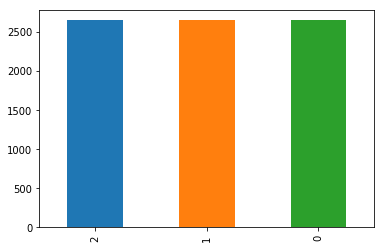

In [75]:
train2 = train.copy()
max_count = np.max(train2['score'].value_counts())
addition = []
for cat in range(3):
    train2_cat = train2[train2['score'] == cat]
    diff = max_count - len(train2_cat)
    addition.append(train2_cat.sample(n=diff, replace=True))
train2 = train2.append(addition, ignore_index=True).reset_index()
train2['score'].value_counts().plot('bar')

### Naive Bayes

In [76]:
nb_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
               ('classifier', MultinomialNB())])
nb_p.fit(train2['review_doc'], train2['score'])
print_metrics(nb_p, train2)

[[2604   28   11]
 [  14 2568   61]
 [  92  178 2373]]
test_f2_score           0.975323
train_accuracy          0.949363
test_accuracy           0.915752
test_f1_macro           0.914007
test_precision_macro    0.921047
test_recall_macro       0.915752
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.231128,0.601653,0.921680,0.920004,0.978480,0.926065,0.921680,0.947787,0.947381,0.982183,0.949186,0.947787
1,0.241009,0.582140,0.913356,0.911773,0.977723,0.918454,0.913356,0.951003,0.950574,0.983866,0.952242,0.951003
2,0.226268,0.586689,0.912221,0.910244,0.969765,0.918623,0.912221,0.949300,0.948961,0.980591,0.950396,0.949300


### Logistic Regression

In [52]:
lr_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', LogisticRegression())])
lr_p.fit(train2['review_doc'], train2['score'])
print_metrics(lr_p, train2)

test_f2_score           0.988515
train_accuracy          0.977362
test_accuracy           0.957372
test_f1_macro           0.956882
test_precision_macro    0.958264
test_recall_macro       0.957372
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.299836,0.587733,0.953840,0.953406,0.982203,0.954108,0.953840,0.977109,0.977010,0.993553,0.977169,0.977109
1,0.294726,0.589707,0.959137,0.958527,0.991670,0.961082,0.959137,0.978623,0.978508,0.995480,0.978777,0.978623
2,0.299142,0.604936,0.959137,0.958714,0.991670,0.959601,0.959137,0.976353,0.976234,0.995480,0.976422,0.976353


### SVM

In [53]:
from sklearn.svm import SVC

svm_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', SVC())])
svm_p.fit(train2['review_doc'], train2['score'])
print_metrics(svm_p, train2)

test_f2_score           0.884912
train_accuracy          0.793543
test_accuracy           0.769454
test_f1_macro           0.764099
test_precision_macro    0.779255
test_recall_macro       0.769454
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,9.934569,18.947560,0.777526,0.773680,0.878657,0.790391,0.777526,0.790957,0.784819,0.907225,0.806055,0.790957
1,9.921907,19.895204,0.781309,0.776670,0.896934,0.788828,0.781309,0.806092,0.802664,0.904470,0.812017,0.806092
2,10.073770,19.390655,0.749527,0.741945,0.879144,0.758545,0.749527,0.783579,0.777397,0.902599,0.794670,0.783579


### Ensemble

In [54]:
from sklearn.ensemble import VotingClassifier

vcl = VotingClassifier([('svc', svm_p),('tonal', tonal_p), ('lr', lr_p)])
vcl.fit(train2['review_doc'], train2['score'])
print_metrics(vcl, train2)

test_f2_score           0.928553
train_accuracy          0.877349
test_accuracy           0.856855
test_f1_macro           0.854436
test_precision_macro    0.864709
test_recall_macro       0.856855
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,10.841213,24.156115,0.867575,0.865950,0.929565,0.874892,0.867575,0.874953,0.872663,0.942524,0.883477,0.874953
1,11.198159,24.070605,0.855089,0.852891,0.929643,0.862664,0.855089,0.883655,0.882533,0.938088,0.888875,0.883655
2,10.716918,23.221519,0.847900,0.844468,0.926451,0.856571,0.847900,0.873439,0.871258,0.941862,0.880257,0.873439


### Conclusions
Here we see a huge boost in the f2 metric, but if wee look closely at confustion matrix we see that really there is no gain in performance. It's just that number of examples 

We see that results improved, especially Logistic Regression have the best f1

## Downsampled data

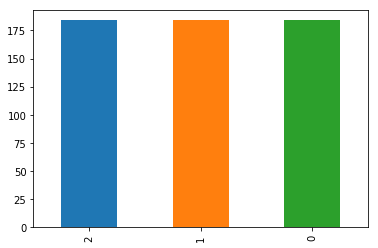

In [55]:
train3 = train.copy()
min_count = np.min(train3['score'].value_counts())
train3_comps = []
for cat in range(3):
    train3_cat = train3[train3['score'] == cat]
    train3_comps.append(train3_cat.sample(n=min_count, replace=True))
train3 = pd.concat(train3_comps, ignore_index=True).reset_index()
train3 = train3.sample(n=len(train3))
train3['score'].value_counts().plot('bar')

### Naive Bayes

In [64]:
nb_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', MultinomialNB())])
nb_p.fit(train3['review_doc'], train3['score'])
print_metrics(nb_p, train3)

[[179   5   0]
 [  0 181   3]
 [  2  12 170]]
test_f2_score           0.722671
train_accuracy          0.974655
test_accuracy           0.669898
test_f1_macro           0.671457
test_precision_macro    0.692475
test_recall_macro       0.669898
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.024284,0.042361,0.741935,0.742494,0.803859,0.784261,0.741935,0.980874,0.980871,1.000000,0.981064,0.980874
1,0.020732,0.043866,0.677596,0.680046,0.695364,0.686954,0.677596,0.978320,0.978393,0.985342,0.978742,0.978320
2,0.019290,0.047403,0.590164,0.591830,0.668790,0.606209,0.590164,0.964770,0.964621,0.991935,0.964872,0.964770


### Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression

lr_p = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', LogisticRegression())])
lr_p.fit(train3['review_doc'], train3['score'])
print_metrics(lr_p, train3)

[[183   0   1]
 [  0 182   2]
 [  0   0 184]]
test_f2_score           0.710669
train_accuracy          0.992751
test_accuracy           0.704507
test_f1_macro           0.700739
test_precision_macro    0.706169
test_recall_macro       0.704507
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.035170,0.046904,0.741935,0.741005,0.801282,0.740841,0.741935,0.991803,0.991825,0.993432,0.992000,0.991803
1,0.033348,0.047169,0.683060,0.677943,0.616438,0.693621,0.683060,0.991870,0.991891,0.993485,0.992063,0.991870
2,0.032253,0.045992,0.688525,0.683269,0.714286,0.684046,0.688525,0.994580,0.994580,1.000000,0.994667,0.994580


### SVM

In [66]:
from sklearn.svm import SVC

svm_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', SVC(C=0.8))])
svm_p.fit(train3['review_doc'], train3['score'])
print_metrics(svm_p, train3)


[[179   5   0]
 [ 14 166   4]
 [ 23  45 116]]
test_f2_score           0.701843
train_accuracy          0.876664
test_accuracy           0.617692
test_f1_macro           0.610187
test_precision_macro    0.668332
test_recall_macro       0.617692
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.079648,0.143731,0.629032,0.613438,0.659164,0.715772,0.629032,0.822404,0.817058,0.849359,0.840658,0.822404
1,0.072477,0.135470,0.622951,0.627939,0.665584,0.656631,0.622951,0.918699,0.918595,0.969305,0.925633,0.918699
2,0.065047,0.141134,0.601093,0.589184,0.780781,0.632593,0.601093,0.888889,0.886495,0.965190,0.895417,0.888889


Let's stick with linear regression and use more features with upsamped dataset

### Linear Regression

#### tf-idf

#### Regularization

In [29]:
gs = GridSearchCV(lr_p, {'classifier__C': [0.01,0.03,0.1,0.3,1,3,10,30]}, scoring='f1_macro', cv=11)
gs.fit(train2['review_doc'],train2['score'])
pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classifier__C,params,rank_test_score,split0_test_score,split0_train_score,split10_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,0.488409,0.036420,0.982880,0.997490,30,{'classifier__C': 30},1,0.976364,0.997641,0.986038,...,0.986046,0.997364,0.984679,0.997503,0.984649,0.997503,0.039212,0.007770,0.004645,0.000172
6,0.448051,0.032365,0.980336,0.996670,10,{'classifier__C': 10},2,0.974967,0.997363,0.984630,...,0.977707,0.995977,0.981859,0.996809,0.983248,0.996531,0.007190,0.001251,0.004549,0.000374
5,0.415743,0.032976,0.974073,0.990930,3,{'classifier__C': 3},3,0.969392,0.991383,0.979018,...,0.976300,0.991386,0.979038,0.990831,0.974804,0.990274,0.007277,0.002048,0.004583,0.000750
4,0.400973,0.033115,0.964587,0.979992,1,{'classifier__C': 1},4,0.948274,0.979236,0.970620,...,0.970671,0.981592,0.972055,0.979233,0.964931,0.979648,0.009194,0.002035,0.007259,0.000800
3,0.388820,0.032674,0.943141,0.958087,0.3,{'classifier__C': 0.3},5,0.938657,0.957804,0.942509,...,0.943827,0.958050,0.941280,0.956257,0.949540,0.959035,0.007003,0.001420,0.003293,0.000889


In [799]:
np.arange(0,1.0,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])